# HW1: Transfer Learning

Tufts CS 152 L3D, Fall 2024

Official Instructions: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html>

## Configuration

This assignment might take a while.
We recommend setting several variables here that prevent repeating long-running tasks.

In [1]:
device = 'cuda' # TODO change to GPU if you have one (e.g. on Colab)

PROB1_res_file = 'prob1_results.pkl'
PROB2_res_file = 'prob2_results.pkl'
PROB1_EXPERIMENTS = True  # Flag will skip re-running experiments if set to False
PROB1_PLOTS = True
PROB2_EXPERIMENTS = True
PROB2_PLOTS = True

# Environment setup

**Option 1: Colab**
To use this notebook with Google Colab, you will need an account and Google Drive storage (free tier just fine)

Please be sure you are *logged in* and have given requisite permission to access Drive to Google Colab.

The lines below will:

* Make folders called `CS152L3D_2024f/HW1/` in your google drive
* Clone the HW1 starter code repository there
* Note: Colab expects *this notebook* (or any notebook) will be in `Colab Notebooks/`.

That will let us use the starter code in this notebook.

**Option 2: Local**

You can also try to use your local machine (but if you don't have a GPU, this may be slow and painful.
If you choose this route, the lines below specific to Colab will just be skipped, and nothing will be done.

In [2]:
import sys
import os

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    COLAB = True
except ImportError:
    COLAB = False

In [4]:
if COLAB:
    if not os.path.exists(os.path.join('/content/drive/MyDrive/', 'CS152L3D_2024f')):
        !cd /content/drive/MyDrive/ && mkdir CS152L3D_2024f


In [5]:
# Move notebook working directory into the folder
if COLAB:
    %cd /content/drive/MyDrive/CS152L3D_2024f/

    # Clone the repo
    if not os.path.exists('cs152l3d-24f-assignments/hw1/'):
      !git clone https://github.com/tufts-ml-courses/cs152l3d-24f-assignments

    # cd into repo
    %cd cs152l3d-24f-assignments/hw1/

Check for success. We should be able to see files like

* model.py
* data_utils.py

In [6]:
!ls

README.md
__pycache__
best_model.pth
birdsnap10
birdsnap10_224x224only.zip
data_utils.py
hw1.ipynb
hw1.zip
hw1_template.tex
l3d_24f_cpu.yml
l3d_24f_cuda.yml
models.py
prob1_results.pkl
resnet10-1253-88a5961b.pth
resnet10_cub-2777-4525b593.pth
resnet26-0849-4bfbc640.pth
resnet26_cub-2316-599ab467.pth
train.py


In [7]:
if COLAB:
    try:
        import torchinfo
        import pytorchcv
    except ImportError:
        rstr = '''
            torchinfo
            pytorchcv
            '''
        with open('colab_requirements.txt', 'w') as f:
            f.write(rstr)
        !pip install -r colab_requirements.txt
        import torchinfo
        import pytorchcv


In [8]:
DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('./birdsnap10'))
print(DATA_DIR)


C:\Users\arman\Documents\CS152_L3D\hw1\birdsnap10


In [9]:
if not os.path.exists(DATA_DIR):
    !unzip birdsnap10_224x224only.zip

In [10]:
# Show contents of train set
!ls $DATA_DIR/train/

American_Black_Duck
Golden_Eagle
Great_Horned_Owl
Harlequin_Duck
Osprey
Peregrine_Falcon
Prairie_Falcon
Short_eared_Owl
White_Ibis
White_faced_Ibis


# Import Libraries

In [11]:
# Import third-party library modules
import json
import pickle
import itertools
import tqdm

In [12]:
import numpy as np
import pandas as pd

In [13]:
import torchinfo
import pytorchcv
import torch
import torchvision

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8') # pretty matplotlib plots
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Import starter code modules from local files

Use **autoreload** so that any changes to these local files will be automatically reloaded into this nb

In [15]:
%load_ext autoreload
%autoreload 2

In [70]:
# Import utils from provided local starter code files
import data_utils
import models
import train

In [57]:
# Re-run this cell if you've made changes to your local file, but they aren't reflected in current nb kernel state
import importlib
importlib.reload(models);
importlib.reload(train);


# Show basic ResNet10 architecture

Load ResNet10. All layers trainable by default.

In [58]:
resnet10_in = models.PretrainedResNetForBirdSnap10(
    src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1)

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


Pretty-print layer-by-layer info

In [59]:
torchinfo.summary(resnet10_in, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                           Output Shape       Param #
PretrainedResNetForBirdSnap10 (PretrainedResNetForBirdSnap10)     [1, 10]            --
├─ResNet (model)                                                  [1, 10]            --
│    └─Sequential (features)                                      [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                             [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                                   [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                                   [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                                   [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                                   [1, 512, 7, 7]     (3,673,088)
│    │    └─AvgPool2d (final_pool)                                [1, 512, 1, 1]     --
│    └─Linear (output)                                            [1, 10]        

# Load dataset

In [60]:
# Verify data has been extracted correctly and is accessible to load in PyTorch
data_utils.BirdsnapDataset(DATA_DIR)

Dataset BirdsnapDataset
    Number of datapoints: 640
    Root location: C:\Users\arman\Documents\CS152_L3D\hw1\birdsnap10

In [61]:
train_loader, val_loader, test_loader = data_utils.make_birdsnap_data_loaders(DATA_DIR)

splitname  0  1  2  3  4  5  6  7  8  9
    train 40 40 40 40 40 40 40 40 40 40
    valid 10 10 10 10 10 10 10 10 10 10
     test 14 14 14 14 14 14 14 14 14 14


In [62]:
n_valid = float(len(val_loader.dataset))

print(n_valid)

print(len(val_loader))

100.0
2


# Problem 1 Implementation Tasks

In separate windows, you'll need to edit:

* models.py, see task (i) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>
* train.py, see tasks (ii, iii, iv) here: <https://www.cs.tufts.edu/cs/152L3D/2024f/hw1.html#problem1>

Any edits to these files should *automatically* be reflected here in your active nb session, since we used **autoreload** above

Finally, as task (v), complete the implementation of `eval_acc` here to evaluate accuracy on test data

In [63]:
def eval_acc(model, device, test_loader):
    model.to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            
            _, predicted_label = torch.max(outputs, 1)

            correct += (predicted_label == y).sum().item()
            

    return correct / len(test_loader.dataset)

In [64]:
# Dictioary to store model results
task_one_results = {}

# Problem 1 Experiments

We'll now try to fit models for 2 archs (RN10, RN26) and 2 srcdatasets (ImageNet, CUB)

For each one, we'll

* keep n_trainable_layers = 1 ("last layer only" or "linear probing")
* Try to find reasonable settings of learning rate (lr), l2 penalty strength (l2pen_mag), and random seed (controls initialization and data order)

**TODO: Last-layer training of ResNet10 from ImageNet1k.**

Need to find good hyperparameters (seed, lr, l2penalty magnitude, n_epochs)

Don't peek at test, just use validation to tune.

In [71]:
if PROB1_EXPERIMENTS:
    seed = 15
    n_epochs=200
    lr=0.001
    l2pen_mag=0.1
    resnet10_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)
    best_model, best_info = train.train_model(resnet10_in, device, train_loader, val_loader,
        n_epochs=n_epochs,
        lr=lr,
        l2pen_mag=l2pen_mag,
        data_order_seed=seed,
        )
    task_one_results[('ResNet10', 'ImageNet1k')] = {
        'epochs': best_info['epochs'],          
        'tr': best_info['tr'],                  
        'va': best_info['va'],                  
        'best_tr_err': best_info['best_tr_err'],
        'best_va_err': best_info['best_va_err'],
        'best_va_loss': best_info['best_va_loss'],
        'best_epoch': best_info['best_epoch'],
        'lr': lr,
        'l2pen_mag': l2pen_mag,
        'seed': seed,
    }
                                                         



Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


  0%| | 1/201 [00:00<01:35,  2.09it/s, tr_xent=nan, tr_err=

torch.Size([10, 512])
torch.Size([10, 512])


  0%| | 1/201 [00:01<01:35,  2.09it/s, tr_xent=nan, tr_err=

torch.Size([10, 512])
torch.Size([10, 512])


  0%| | 1/201 [00:01<01:35,  2.09it/s, tr_xent=nan, tr_err=

torch.Size([10, 512])
torch.Size([10, 512])


  0%| | 1/201 [00:01<01:35,  2.09it/s, tr_xent=nan, tr_err=

torch.Size([10, 512])


  1%| | 2/201 [00:02<03:24,  1.03s/it, tr_xent=2.14, tr_err

torch.Size([10, 512])


KeyboardInterrupt: 

# Diagnostic plot: Error/loss vs epoch

The plot below is just a demo of what you can plot. Values won't represent correct operation of model training until you run the code implementation tasks, and start training for longer (adjust n_epochs > 15).

FYI: good practices already implemented info dict returned by train_model

* Report perf on val on given initial model (epoch=0), before making any updates
* Train perf metrics only kick in for epoch 1 and later (when we are doing updates)

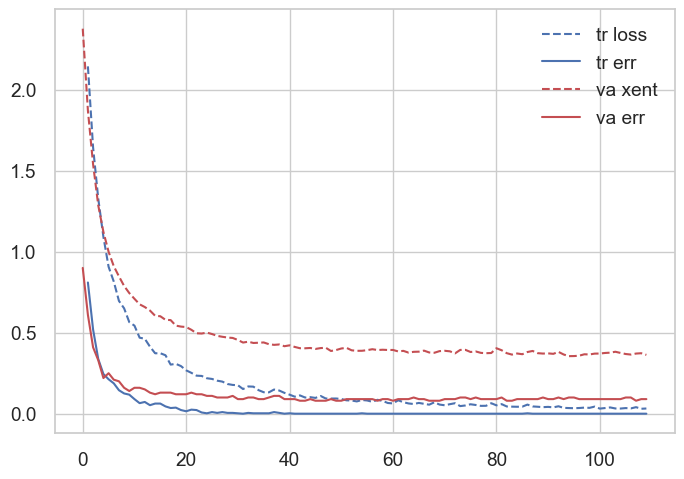

In [26]:
plt.plot(best_info['epochs'], best_info['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info['epochs'], best_info['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info['epochs'], best_info['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info['epochs'], best_info['va']['err'], '-', color='r', label='va err')
plt.legend();

**Pro Tip:** Consider storing your "best" runs to disk, using code like below

In [27]:

# if os.path.exists(PROB1_res_file) and os.path.getsize(PROB1_res_file) > 0:
#     with open(PROB1_res_file, 'rb') as f:
#         results = pickle.load(f)
# else:
#     results = dict()

# results[(src_dataset, arch)] = best_model, best_info

# with open(PROB1_res_file, 'w') as f:
#     pickle.dump(results, f)


**TODO** repeat the above for each config in ('ResNet10', 'ResNet26') and ('ImageNet1k', 'CUB')

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 83%|██████▋ | 167/201 [03:21<00:40,  1.20s/it, tr_xent=0.249, tr_err=0.0375, va_xent=0.946, va_err=0.28, batch_done=7]


Stopped early.
Finished after epoch 167, best epoch=152
best va_xent 0.939
best tr_err 0.043
best va_err 0.300


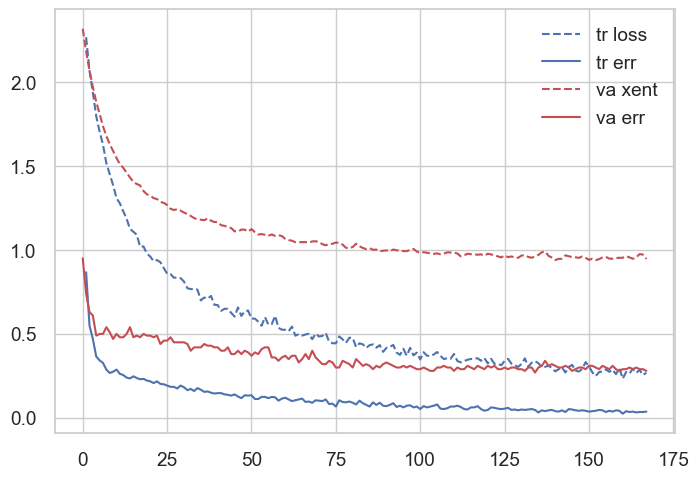

In [28]:
# TODO do tuning expts for Resnet10, CUB

if PROB1_EXPERIMENTS:
    seed = 15
    n_epochs=200,
    lr=0.001,
    l2pen_mag=0.1,
    resnet10_cub = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet10', n_trainable_layers=1, seed=seed)
    best_model, best_info = train.train_model(resnet10_cub, device, train_loader, val_loader,
        n_epochs=200,
        lr=0.001,
        l2pen_mag=0.1,
        data_order_seed=seed,
        )
    
    task_one_results[('ResNet10', 'CUB')] = {
        'epochs': best_info['epochs'],
        'tr': best_info['tr'],
        'va': best_info['va'],
        'best_tr_err': best_info['best_tr_err'],
        'best_va_err': best_info['best_va_err'],
        'best_va_loss': best_info['best_va_loss'],
        'best_epoch': best_info['best_epoch'],
        'lr': lr,
        'l2pen_mag': l2pen_mag,
        'seed': seed,
    }

plt.plot(best_info['epochs'], best_info['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info['epochs'], best_info['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info['epochs'], best_info['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info['epochs'], best_info['va']['err'], '-', color='r', label='va err')
plt.legend();

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 34%|████▍        | 68/201 [01:58<03:52,  1.75s/it, tr_xent=0.0617, tr_err=0, va_xent=0.498, va_err=0.14, batch_done=7]


Stopped early.
Finished after epoch 68, best epoch=53
best va_xent 0.475
best tr_err 0.003
best va_err 0.130


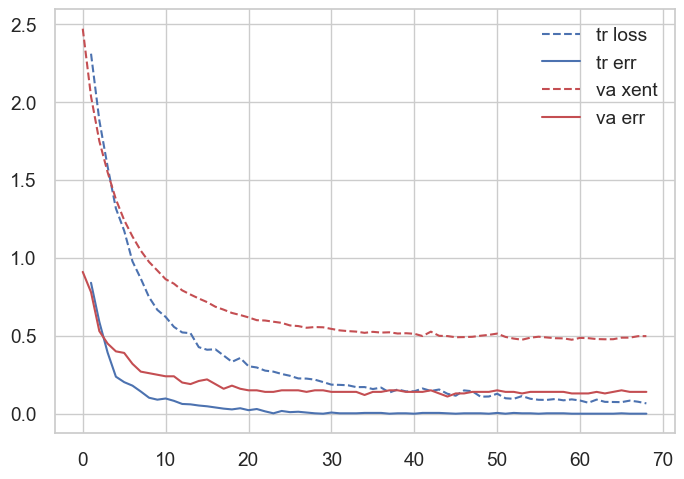

In [29]:
# TODO do tuning expts for Resnet26, ImageNet1k

if PROB1_EXPERIMENTS:
    seed = 1011
    n_epochs=200,
    lr=0.001,
    l2pen_mag=0.0,
    resnet26_in = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet26', n_trainable_layers=1, seed=seed)
    best_model, best_info = train.train_model(resnet26_in, device, train_loader, val_loader,
        n_epochs=200,
        lr=0.001,
        l2pen_mag=0.1,
        data_order_seed=seed,
        )
    task_one_results[('ResNet26', 'ImageNet1k')] = {
        'epochs': best_info['epochs'],
        'tr': best_info['tr'],
        'va': best_info['va'],
        'best_tr_err': best_info['best_tr_err'],
        'best_va_err': best_info['best_va_err'],
        'best_va_loss': best_info['best_va_loss'],
        'best_epoch': best_info['best_epoch'],
        'lr': lr,
        'l2pen_mag': l2pen_mag,
        'seed': seed,
    }


plt.plot(best_info['epochs'], best_info['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info['epochs'], best_info['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info['epochs'], best_info['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info['epochs'], best_info['va']['err'], '-', color='r', label='va err')
plt.legend();

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 61%|██████▋    | 123/201 [03:47<02:24,  1.85s/it, tr_xent=0.26, tr_err=0.045, va_xent=0.84, va_err=0.18, batch_done=7]


Stopped early.
Finished after epoch 123, best epoch=108
best va_xent 0.800
best tr_err 0.043
best va_err 0.180


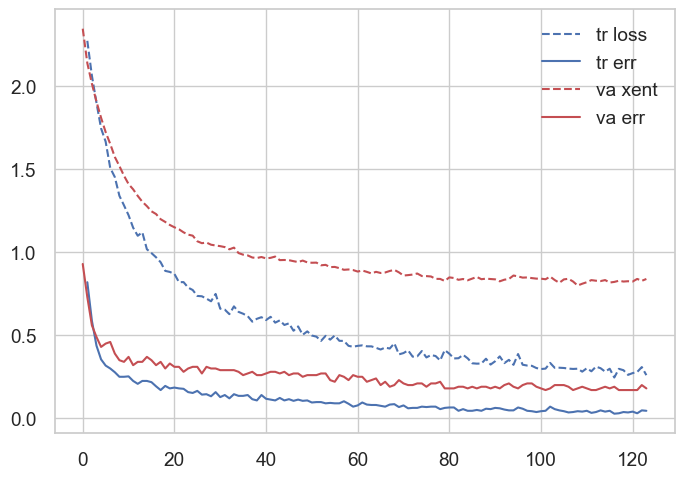

In [30]:
# TODO do tuning expts for Resnet26, CUB

if PROB1_EXPERIMENTS:
    seed = 1011
    n_epochs=200,
    lr=0.001,
    l2pen_mag=0.0,
    resnet26_cub = models.PretrainedResNetForBirdSnap10(
        src_dataset='CUB', arch='ResNet26', n_trainable_layers=1, seed=seed)
    best_model, best_info = train.train_model(resnet26_cub, device, train_loader, val_loader,
        n_epochs=200,
        lr=0.001,
        l2pen_mag=0.0,
        data_order_seed=seed,
        )
    task_one_results[('ResNet26', 'CUB')] = {
        'epochs': best_info['epochs'],
        'tr': best_info['tr'],
        'va': best_info['va'],
        'best_tr_err': best_info['best_tr_err'],
        'best_va_err': best_info['best_va_err'],
        'best_va_loss': best_info['best_va_loss'],
        'best_epoch': best_info['best_epoch'],
        'lr': lr,
        'l2pen_mag': l2pen_mag,
        'seed': seed,
    }

plt.plot(best_info['epochs'], best_info['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info['epochs'], best_info['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info['epochs'], best_info['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info['epochs'], best_info['va']['err'], '-', color='r', label='va err')
plt.legend();

In [31]:
# # GRID SEARCH:

# gridsearch_params = {
#     'seed': [3,5,15,23,91,96,24,69,66],
#     'lr': [0.1,0.01,0.001],
#     'l2pen_mag': [0.0,0.1],
#     'n_epochs': [200]
# }


# hyparam_combinations = list(itertools.product(
#     gridsearch_params['seed'],
#     gridsearch_params['lr'],
#     gridsearch_params['l2pen_mag'],
#     gridsearch_params['n_epochs']
# ))


# best_model = None
# best_info = None
# best_val_loss = float('inf')


# for seed, lr, l2pen_mag, n_epochs in hyparam_combinations:
#     print(f"Running experiment with seed={seed}, lr={lr}, l2pen_mag={l2pen_mag}, n_epochs={n_epochs}")
    
#     model = models.PretrainedResNetForBirdSnap10(
#         src_dataset='ImageNet1k', arch='ResNet26', n_trainable_layers=1, seed=seed
#     )
    

#     trained_model, train_info = train.train_model(
#         model,
#         device,
#         train_loader,
#         val_loader,
#         n_epochs=n_epochs,
#         lr=lr,
#         l2pen_mag=l2pen_mag,
#         data_order_seed=seed,
#     )
    
#     val_loss = train_info['va']['xent'][-1]

#     print(f"Validation loss: {val_loss}")

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model = trained_model
#         best_info = train_info
#         print("NEW BEST MODEL")





# plt.figure(figsize=(10, 5))
# plt.plot(best_info['epochs'], best_info['tr']['loss'], '--', color='b', label='tr loss')
# plt.plot(best_info['epochs'], best_info['tr']['err'], '-', color='b', label='tr err')

# plt.plot(best_info['epochs'], best_info['va']['xent'], '--', color='r', label='va xent')
# plt.plot(best_info['epochs'], best_info['va']['err'], '-', color='r', label='va err')
# plt.xlabel('Epochs')
# plt.ylabel('Loss / Error')
# plt.title('Training and Validation Loss/Errors')
# plt.legend()
# plt.grid()
# plt.show()

# Problem 1 Analysis and Plotting

In [32]:
# # Create dummy results so we can show what kind of plots we want
# dummy_result = {}

# eps = np.arange(20)

# dummy_result[('ResNet10', 'ImageNet1k')] = dict(
#     lr = 0.123,
#     l2pen_mag = 0.0,
#     seed = 42,
#     epochs=eps,
#     tr=dict(
#         loss=.7 - .3 * (1 - np.abs(eps-10) / 10), # upside-down triangle
#         xent=.68 - .3 * (1 - np.abs(eps-10) / 10), # upside-down triangle
#         err=.01 * np.ones(20),
#     ),
#     va=dict(
#         xent=.8 - .2 * (1 - np.abs(eps-10) / 10), # upside-down triangle
#         err=.1 * np.ones(20),
#     ),
#     best_epoch=10,
#     best_va_loss=0.6,
# )

# eps = np.arange(30)
# dummy_result[('ResNet10', 'CUB')] = dict(
#     lr = 0.456,
#     l2pen_mag = 0.0,
#     seed = 42,
#     epochs=eps,
#     tr=dict(
#         loss=.7 - .3 * (1 - np.abs(eps-15) / 15),  # upside-down triangle
#         xent=.68 - .3 * (1 - np.abs(eps-15) / 15), # upside-down triangle
#         err=.01 * np.ones(30),
#     ),
#     va=dict(
#         xent=.9 - .3 * (1 - np.abs(eps-15) / 15), # upside-down triangle
#         err=.1 * np.ones(30),
#     ),
#     best_epoch=15,
#     best_va_loss=0.6,
# )

## Figure 1a: Loss over Epochs

Starter code notebook indicates style of plot desired.

**TODO** Your job is to make sure the plot shows your *real* results, not our dummy results.

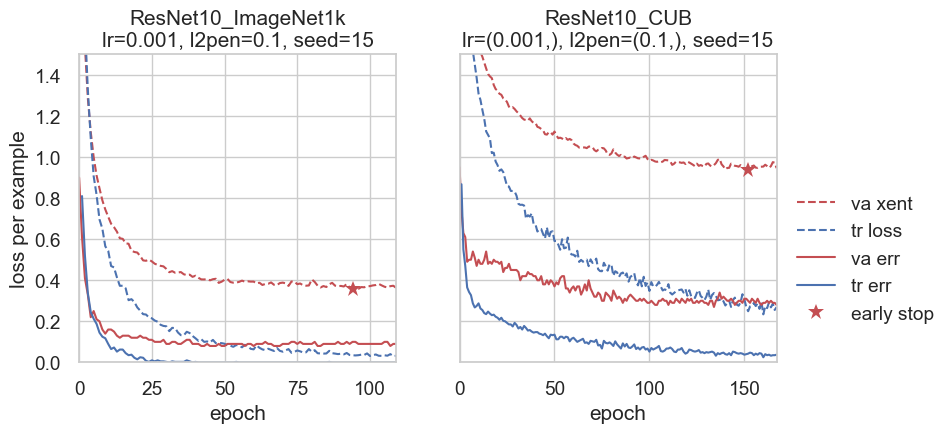

In [33]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=False)

for panel_id, (arch, src_dataset) in enumerate([
        ('ResNet10', 'ImageNet1k'),
        ('ResNet10', 'CUB'),
        ]):
    ax = axgrid[panel_id]
    key = (arch, src_dataset)

    # Importing best model results
    info = task_one_results[key]

    ax.plot(info['epochs'], info['va']['xent'], '--', color='r', label='va xent')
    ax.plot(info['epochs'], info['tr']['loss'], '--', color='b', label='tr loss')
    ax.plot(info['epochs'], info['va']['err'], label='va err', color='r')
    ax.plot(info['epochs'], info['tr']['err'], label='tr err', color='b')
    ax.plot(info['best_epoch'], info['best_va_loss'], '*', color='r', markersize=12, label='early stop')
    ax.set_xlabel('epoch')
    if panel_id == 0:
        ax.set_ylabel('loss per example')
    lr = info['lr']
    l2pen = info['l2pen_mag']
    seed = info['seed']
    ax.set_title(f'{arch}_{src_dataset}\nlr={lr}, l2pen={l2pen}, seed={seed}')
    ax.set_xlim([-0.001, max(info['epochs'])])

ax.set_ylim([0.0, 1.5]);
ax.legend(bbox_to_anchor=(1.55, 0.6));

## Figure 1b: Target Acc vs Source Acc

**TODO** Lookup source task accuracy (use top1 if needed) from pytorch cv webpage: https://pypi.org/project/pytorchcv/


In [34]:
src_acc = {}
src_acc[('ResNet10', 'ImageNet1k')] = 1 - 0.3243
src_acc[('ResNet26', 'ImageNet1k')] = 1 - 0.2616

src_acc[('ResNet10', 'CUB')] = 1 - 0.2777
src_acc[('ResNet26', 'CUB')] = 1 - 0.2316

**TODO** Measure your best model accuracy using provided test_loader and `eval_acc` function, record values here

In [47]:
tar_acc = {}
tar_acc[('ResNet10', 'ImageNet1k')] = eval_acc(resnet10_in, device, test_loader)
tar_acc[('ResNet26', 'ImageNet1k')] = eval_acc(resnet26_in, device, test_loader)

tar_acc[('ResNet10', 'CUB')] = eval_acc(resnet10_cub, device, test_loader)
tar_acc[('ResNet26', 'CUB')] = eval_acc(resnet26_cub, device, test_loader)

In [48]:
print(tar_acc)

print(src_acc)

{('ResNet10', 'ImageNet1k'): 0.8071428571428572, ('ResNet26', 'ImageNet1k'): 0.8571428571428571, ('ResNet10', 'CUB'): 0.4857142857142857, ('ResNet26', 'CUB'): 0.4928571428571429}
{('ResNet10', 'ImageNet1k'): 0.6757, ('ResNet26', 'ImageNet1k'): 0.7384, ('ResNet10', 'CUB'): 0.7222999999999999, ('ResNet26', 'CUB'): 0.7684}


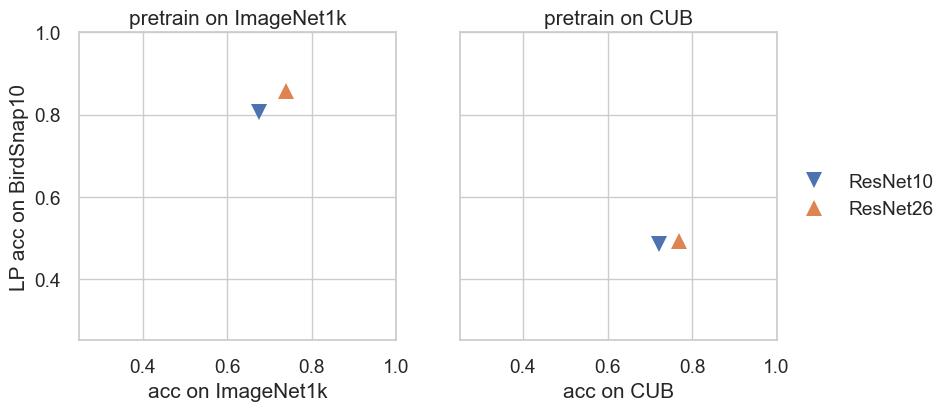

In [49]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

arch_list = ['ResNet10', 'ResNet26']
srcdata_list = ['ImageNet1k', 'CUB']

for (arch, src_dataset) in itertools.product(arch_list, srcdata_list):
    if src_dataset.count("ImageNet"):
        panel_id = 0
    else:
        panel_id = 1
    ax = axgrid[panel_id]
    ax.set_title("pretrain on " + src_dataset)
    key = "{arch}_{src_dataset}".format(arch=arch, src_dataset=src_dataset)
    cur_target_acc = tar_acc[(arch, src_dataset)]
    cur_src_acc = src_acc[(arch, src_dataset)]
    ax.plot(cur_src_acc, cur_target_acc, 'v' if arch.count('10') else '^', label=arch, markersize=12)
    ax.set_xlim([0.25, 1.0]); ax.set_xticks([.4, .6, .8, 1]);
    ax.set_ylim([0.25, 1.0]); ax.set_yticks([.4, .6, .8, 1]);
    ax.set_xlabel(f"acc on {src_dataset}");
    if panel_id == 0:
        ax.set_ylabel(f"LP acc on BirdSnap10");
plt.legend(bbox_to_anchor=(1.55, 0.6));

# Problem 2 Experiments

TODO Implement LP-then-FT, via repeated calls to **train_model**

* LP phase should use n_trainable_layers=1 (about 5000 trainable params)
* FT phase should use n_trainable_layers=3 (about 100000 trainable params)

In [38]:
# eps = np.arange(20)

# P2_dummy_result = {}

# # Phase 1, copy hard work from Problem 1
# P2_dummy_result[('ResNet10', 'ImageNet1k','phase1')] = dummy_result[('ResNet10', 'ImageNet1k')]

# eps = np.arange(20)
# P2_dummy_result[('ResNet10', 'ImageNet1k','phase2')] = dict(
#     lr = 0.456,
#     l2pen_mag = 0.0,
#     seed = 42,
#     epochs=np.arange(20),
#     tr=dict(
#         loss=.3 - 0.15 * (eps/max(eps)),
#         err=.01 * np.ones(20),
#     ),
#     va=dict(
#         xent=.6 - 0.15 * (eps/max(eps)),
#         err=.1 * np.ones(20),
#     ),
#     best_epoch=10,
#     best_va_loss=0.6,
#     test_acc=0.1,
# )

In [39]:
from copy import deepcopy

task_two_results = dict()

if PROB2_EXPERIMENTS:
    seed = 15
    n_epochs=200,
    lr=0.001,
    l2pen_mag=0.1,
    resnet10_in_lp = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=1, seed=seed)
    best_model_lp, best_info_lp = train.train_model(resnet10_in_lp, device, train_loader, val_loader,
        n_epochs=200,
        lr=0.001,
        l2pen_mag=0.1,
        data_order_seed=seed,
        )
    task_two_results[('ResNet10', 'ImageNet1k', 'phase1')] = {
        'epochs': best_info_lp['epochs'],
        'tr': best_info_lp['tr'],        
        'va': best_info_lp['va'],        
        'best_tr_err': best_info_lp['best_tr_err'],
        'best_va_err': best_info_lp['best_va_err'],
        'best_va_loss': best_info_lp['best_va_loss'],
        'best_epoch': best_info_lp['best_epoch'],
        'lr': lr,
        'l2pen_mag': l2pen_mag,
        'seed': seed,
    }

    seed = 23
    resnet10_in_ft = models.PretrainedResNetForBirdSnap10(
        src_dataset='ImageNet1k', arch='ResNet10', n_trainable_layers=3, seed=seed)

    lp_model_copy = deepcopy(resnet10_in_lp.state_dict())
    
    resnet10_in_ft.load_state_dict(lp_model_copy)
    
    best_model_ft, best_info_ft = train.train_model(resnet10_in_ft, device, train_loader, val_loader,
        n_epochs=200,
        lr=0.001,
        l2pen_mag=0.1, 
        data_order_seed=seed,
        )
    task_two_results[('ResNet10', 'ImageNet1k', 'phase2')] = {
        'epochs': best_info_ft['epochs'],          
        'tr': best_info_ft['tr'],                  
        'va': best_info_ft['va'],                  
        'best_tr_err': best_info_ft['best_tr_err'],
        'best_va_err': best_info_ft['best_va_err'],
        'best_va_loss': best_info_ft['best_va_loss'],
        'best_epoch': best_info_ft['best_epoch'],
        'lr': lr,
        'l2pen_mag': l2pen_mag,
        'seed': seed,
    }
                     

Setup complete. Trainable parameter count=5130 over 2 tensors in layers: output.


 54%|██████▌     | 109/201 [02:11<01:51,  1.21s/it, tr_xent=0.0277, tr_err=0, va_xent=0.363, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 109, best epoch=94
best va_xent 0.355
best tr_err 0.000
best va_err 0.100
Setup complete. Trainable parameter count=137226 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


 15%|█▊          | 31/201 [00:39<03:34,  1.26s/it, tr_xent=0.00186, tr_err=0, va_xent=0.338, va_err=0.09, batch_done=7]

Stopped early.
Finished after epoch 31, best epoch=16
best va_xent 0.311
best tr_err 0.000
best va_err 0.090


Running experiment with seed=3, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:19<03:58,  1.28s/it, tr_xent=0.000185, tr_err=0, va_xent=1.14, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 1.1392908096313477
NEW BEST MODEL
Running experiment with seed=3, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:20<04:17,  1.38s/it, tr_xent=0.000629, tr_err=0, va_xent=0.519, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.5192918586730957
NEW BEST MODEL
Running experiment with seed=3, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:21<04:23,  1.42s/it, tr_xent=0.000442, tr_err=0, va_xent=1.15, va_err=0.14, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 1.1454432678222655
Running experiment with seed=3, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:18<03:54,  1.26s/it, tr_xent=0.000626, tr_err=0, va_xent=0.437, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4374179744720459
NEW BEST MODEL
Running experiment with seed=3, lr=0.01, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:20<04:08,  1.34s/it, tr_xent=0.000726, tr_err=0, va_xent=0.427, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.42729700088500977
NEW BEST MODEL
Running experiment with seed=3, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:20<04:17,  1.38s/it, tr_xent=0.000669, tr_err=0, va_xent=0.439, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4388257884979248
Running experiment with seed=3, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:18<03:51,  1.24s/it, tr_xent=0.000652, tr_err=0, va_xent=0.415, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4145444297790527
NEW BEST MODEL
Running experiment with seed=3, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:18<03:55,  1.27s/it, tr_xent=0.000995, tr_err=0, va_xent=0.418, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4178703117370606
Running experiment with seed=3, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:22<04:39,  1.50s/it, tr_xent=0.000683, tr_err=0, va_xent=0.415, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.41541690826416017
Running experiment with seed=5, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:19<03:57,  1.28s/it, tr_xent=0.000402, tr_err=0, va_xent=0.86, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.8599952316284181
Running experiment with seed=5, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:19<03:59,  1.29s/it, tr_xent=0.00124, tr_err=0, va_xent=0.929, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.929438591003418
Running experiment with seed=5, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▉            | 15/201 [00:19<03:59,  1.29s/it, tr_xent=0.00121, tr_err=0, va_xent=0.74, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.7401115417480468
Running experiment with seed=5, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:17<03:39,  1.18s/it, tr_xent=0.000897, tr_err=0, va_xent=0.497, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.496928768157959
Running experiment with seed=5, lr=0.01, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:17<03:42,  1.20s/it, tr_xent=0.000785, tr_err=0, va_xent=0.429, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.42892641067504883
Running experiment with seed=5, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:19<03:56,  1.27s/it, tr_xent=0.00121, tr_err=0, va_xent=0.503, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.5030978393554688
Running experiment with seed=5, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:18<03:55,  1.26s/it, tr_xent=0.000441, tr_err=0, va_xent=0.405, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4051557731628418
NEW BEST MODEL
Running experiment with seed=5, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:18<03:43,  1.20s/it, tr_xent=0.00106, tr_err=0, va_xent=0.376, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.3756895637512207
NEW BEST MODEL
Running experiment with seed=5, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:19<04:00,  1.29s/it, tr_xent=0.000488, tr_err=0, va_xent=0.401, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.40147119522094726
Running experiment with seed=15, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:20<04:12,  1.36s/it, tr_xent=0.000269, tr_err=0, va_xent=0.714, va_err=0.14, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.7138054275512695
Running experiment with seed=15, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:23<04:47,  1.55s/it, tr_xent=0.000358, tr_err=0, va_xent=0.855, va_err=0.16, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.8554145050048828
Running experiment with seed=15, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:18<03:51,  1.25s/it, tr_xent=0.000808, tr_err=0, va_xent=0.772, va_err=0.14, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.7721849822998047
Running experiment with seed=15, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:18<03:44,  1.20s/it, tr_xent=0.00223, tr_err=0, va_xent=0.553, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.5527755546569824
Running experiment with seed=15, lr=0.01, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:19<03:57,  1.28s/it, tr_xent=0.00262, tr_err=0, va_xent=0.381, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.38078678131103516
Running experiment with seed=15, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:18<03:46,  1.22s/it, tr_xent=0.00206, tr_err=0, va_xent=0.502, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.5023070907592773
Running experiment with seed=15, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:18<03:50,  1.24s/it, tr_xent=0.00106, tr_err=0, va_xent=0.429, va_err=0.08, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.42907686233520503
Running experiment with seed=15, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|█             | 15/201 [00:19<03:56,  1.27s/it, tr_xent=0.00174, tr_err=0, va_xent=0.41, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4102412414550781
Running experiment with seed=15, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:18<03:48,  1.23s/it, tr_xent=0.00113, tr_err=0, va_xent=0.427, va_err=0.08, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4274850845336914
Running experiment with seed=23, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:18<03:54,  1.26s/it, tr_xent=0.00171, tr_err=0, va_xent=0.626, va_err=0.14, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.6264970588684082
Running experiment with seed=23, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▋        | 15/201 [00:19<03:58,  1.28s/it, tr_xent=0.0147, tr_err=0.0025, va_xent=1.03, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 1.0289684677124025
Running experiment with seed=23, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▌       | 15/201 [00:18<03:54,  1.26s/it, tr_xent=0.00495, tr_err=0.0025, va_xent=1.09, va_err=0.17, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 1.0881352996826172
Running experiment with seed=23, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:18<03:50,  1.24s/it, tr_xent=0.00316, tr_err=0, va_xent=0.444, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4437692070007324
Running experiment with seed=23, lr=0.01, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:19<03:55,  1.27s/it, tr_xent=0.00336, tr_err=0, va_xent=0.399, va_err=0.08, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.39893712997436526
Running experiment with seed=23, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:18<03:52,  1.25s/it, tr_xent=0.00312, tr_err=0, va_xent=0.445, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4447969627380371
Running experiment with seed=23, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:18<03:54,  1.26s/it, tr_xent=0.000516, tr_err=0, va_xent=0.361, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.3612488555908203
NEW BEST MODEL
Running experiment with seed=23, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:18<03:50,  1.24s/it, tr_xent=0.00214, tr_err=0, va_xent=0.322, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.32200141906738283
NEW BEST MODEL
Running experiment with seed=23, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:18<03:55,  1.27s/it, tr_xent=0.00059, tr_err=0, va_xent=0.355, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.35477331161499026
Running experiment with seed=91, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:18<03:54,  1.26s/it, tr_xent=0.000427, tr_err=0, va_xent=0.857, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.8566231918334961
Running experiment with seed=91, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:19<03:55,  1.27s/it, tr_xent=0.00536, tr_err=0, va_xent=0.709, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.7088279724121094
Running experiment with seed=91, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:18<03:52,  1.25s/it, tr_xent=0.000693, tr_err=0, va_xent=0.897, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.8968546295166016
Running experiment with seed=91, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:19<04:01,  1.30s/it, tr_xent=0.00134, tr_err=0, va_xent=0.466, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4661308860778809
Running experiment with seed=91, lr=0.01, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:18<03:52,  1.25s/it, tr_xent=0.00129, tr_err=0, va_xent=0.445, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4454070281982422
Running experiment with seed=91, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:19<04:02,  1.30s/it, tr_xent=0.00139, tr_err=0, va_xent=0.465, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4649295997619629
Running experiment with seed=91, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:19<03:58,  1.28s/it, tr_xent=0.000429, tr_err=0, va_xent=0.367, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.3670512199401855
Running experiment with seed=91, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:19<04:00,  1.30s/it, tr_xent=0.000779, tr_err=0, va_xent=0.351, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.3513933944702149
Running experiment with seed=91, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:19<03:58,  1.28s/it, tr_xent=0.000458, tr_err=0, va_xent=0.365, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.3646964454650879
Running experiment with seed=96, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:19<03:57,  1.28s/it, tr_xent=0.000178, tr_err=0, va_xent=0.867, va_err=0.15, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.8671652221679688
Running experiment with seed=96, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:18<03:54,  1.26s/it, tr_xent=0.00041, tr_err=0, va_xent=0.752, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.7517612457275391
Running experiment with seed=96, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:19<03:57,  1.28s/it, tr_xent=0.000192, tr_err=0, va_xent=0.805, va_err=0.15, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.8047025680541993
Running experiment with seed=96, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:19<04:01,  1.30s/it, tr_xent=0.000969, tr_err=0, va_xent=0.498, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.4979997253417969
Running experiment with seed=96, lr=0.01, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:19<04:00,  1.29s/it, tr_xent=0.000712, tr_err=0, va_xent=0.425, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.42515235900878906
Running experiment with seed=96, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:20<04:18,  1.39s/it, tr_xent=0.000877, tr_err=0, va_xent=0.489, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.48859926223754885
Running experiment with seed=96, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:21<04:22,  1.41s/it, tr_xent=0.000689, tr_err=0, va_xent=0.375, va_err=0.08, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.37532032012939454
Running experiment with seed=96, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:19<04:04,  1.31s/it, tr_xent=0.000881, tr_err=0, va_xent=0.358, va_err=0.08, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.3582583236694336
Running experiment with seed=96, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:18<03:47,  1.22s/it, tr_xent=0.000707, tr_err=0, va_xent=0.374, va_err=0.08, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.37351083755493164
Running experiment with seed=24, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:20<04:08,  1.34s/it, tr_xent=0.000261, tr_err=0, va_xent=1.07, va_err=0.15, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 1.0686256790161133
Running experiment with seed=24, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:19<03:57,  1.28s/it, tr_xent=0.000543, tr_err=0, va_xent=1.18, va_err=0.15, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 1.1842524337768556
Running experiment with seed=24, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:18<03:54,  1.26s/it, tr_xent=0.000266, tr_err=0, va_xent=1.06, va_err=0.16, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 1.0622192764282226
Running experiment with seed=24, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:19<04:05,  1.32s/it, tr_xent=0.000839, tr_err=0, va_xent=0.341, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.311
best tr_err nan
best va_err 0.090
Validation loss: 0.3414819812774658
Running experiment with seed=24, lr=0.01, l2pen_mag=0.1, n_epochs=200


 14%|█▊           | 28/201 [00:35<03:41,  1.28s/it, tr_xent=0.00137, tr_err=0, va_xent=0.331, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 28, best epoch=13
best va_xent 0.306
best tr_err 0.000
best va_err 0.110
Validation loss: 0.33105787277221677
Running experiment with seed=24, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▉            | 15/201 [00:20<04:08,  1.34s/it, tr_xent=0.0001, tr_err=0, va_xent=0.487, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.306
best tr_err nan
best va_err 0.110
Validation loss: 0.4874382972717285
Running experiment with seed=24, lr=0.001, l2pen_mag=0.0, n_epochs=200


  8%|▉          | 17/201 [00:22<04:05,  1.34s/it, tr_xent=0.000104, tr_err=0, va_xent=0.354, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 17, best epoch=2
best va_xent 0.305
best tr_err 0.000
best va_err 0.110
Validation loss: 0.3543301200866699
Running experiment with seed=24, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:19<03:58,  1.28s/it, tr_xent=0.000435, tr_err=0, va_xent=0.347, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.34691534042358396
Running experiment with seed=24, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:20<04:20,  1.40s/it, tr_xent=6.61e-5, tr_err=0, va_xent=0.407, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.4067929649353027
Running experiment with seed=69, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:19<04:01,  1.30s/it, tr_xent=0.000378, tr_err=0, va_xent=0.776, va_err=0.13, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.7756699752807616
Running experiment with seed=69, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|█             | 15/201 [00:20<04:12,  1.36s/it, tr_xent=0.006, tr_err=0, va_xent=0.763, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.7629055786132812
Running experiment with seed=69, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:20<04:11,  1.35s/it, tr_xent=0.000775, tr_err=0, va_xent=0.617, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.61720796585083
Running experiment with seed=69, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:20<04:18,  1.39s/it, tr_xent=0.000541, tr_err=0, va_xent=0.528, va_err=0.14, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.5275158119201661
Running experiment with seed=69, lr=0.01, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:20<04:11,  1.35s/it, tr_xent=0.00123, tr_err=0, va_xent=0.538, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.5379271125793457
Running experiment with seed=69, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▉           | 15/201 [00:20<04:09,  1.34s/it, tr_xent=0.000117, tr_err=0, va_xent=0.564, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.5637617301940918
Running experiment with seed=69, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▊          | 15/201 [00:20<04:10,  1.34s/it, tr_xent=0.000241, tr_err=0, va_xent=0.351, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.3512630558013916
Running experiment with seed=69, lr=0.001, l2pen_mag=0.1, n_epochs=200


  7%|▊          | 15/201 [00:21<04:22,  1.41s/it, tr_xent=0.000743, tr_err=0, va_xent=0.339, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.3387710475921631
Running experiment with seed=69, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:21<04:21,  1.41s/it, tr_xent=0.000284, tr_err=0, va_xent=0.349, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.3492313003540039
Running experiment with seed=66, lr=0.1, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:19<04:06,  1.33s/it, tr_xent=0.000527, tr_err=0, va_xent=0.96, va_err=0.17, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.9599949264526367
Running experiment with seed=66, lr=0.1, l2pen_mag=0.1, n_epochs=200


  7%|▉           | 15/201 [00:20<04:08,  1.34s/it, tr_xent=0.000462, tr_err=0, va_xent=0.685, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.6847286224365234
Running experiment with seed=66, lr=0.1, l2pen_mag=0.01, n_epochs=200


  7%|▊          | 15/201 [00:20<04:16,  1.38s/it, tr_xent=0.000361, tr_err=0, va_xent=0.918, va_err=0.12, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.9181401062011718
Running experiment with seed=66, lr=0.01, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:19<04:05,  1.32s/it, tr_xent=0.000171, tr_err=0, va_xent=0.419, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.305
best tr_err nan
best va_err 0.110
Validation loss: 0.4185989570617676
Running experiment with seed=66, lr=0.01, l2pen_mag=0.1, n_epochs=200


 12%|█▍          | 25/201 [00:33<03:55,  1.34s/it, tr_xent=0.00348, tr_err=0, va_xent=0.345, va_err=0.11, batch_done=7]


Stopped early.
Finished after epoch 25, best epoch=10
best va_xent 0.304
best tr_err 0.000
best va_err 0.100
Validation loss: 0.3446629047393799
Running experiment with seed=66, lr=0.01, l2pen_mag=0.01, n_epochs=200


  7%|▋        | 15/201 [00:18<03:53,  1.26s/it, tr_xent=0.134, tr_err=0.0325, va_xent=0.821, va_err=0.14, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.304
best tr_err nan
best va_err 0.100
Validation loss: 0.8213687705993653
Running experiment with seed=66, lr=0.001, l2pen_mag=0.0, n_epochs=200


  7%|▉           | 15/201 [00:19<03:56,  1.27s/it, tr_xent=3.47e-5, tr_err=0, va_xent=0.399, va_err=0.09, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.304
best tr_err nan
best va_err 0.100
Validation loss: 0.3992569160461426
Running experiment with seed=66, lr=0.001, l2pen_mag=0.1, n_epochs=200


 12%|█▍          | 25/201 [00:31<03:39,  1.25s/it, tr_xent=0.000777, tr_err=0, va_xent=0.353, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 25, best epoch=10
best va_xent 0.295
best tr_err 0.000
best va_err 0.100
Validation loss: 0.3529176044464111
Running experiment with seed=66, lr=0.001, l2pen_mag=0.01, n_epochs=200


  7%|▉            | 15/201 [00:18<03:51,  1.25s/it, tr_xent=8.42e-5, tr_err=0, va_xent=0.433, va_err=0.1, batch_done=7]


Stopped early.
Finished after epoch 15, best epoch=0
best va_xent 0.295
best tr_err nan
best va_err 0.100
Validation loss: 0.4329599094390869


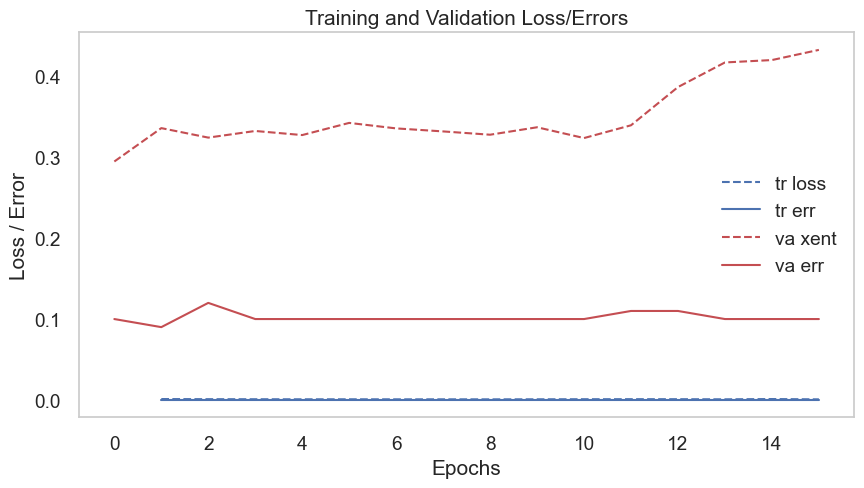

In [45]:
gridsearch_params = {
    'seed': [3,5,15,23,91,96,24,69,66],
    'lr': [0.1,0.01,0.001], 
    'l2pen_mag': [0.0,0.1, 0.01],
    'n_epochs': [200]
}


hyparam_combinations = list(itertools.product(
    gridsearch_params['seed'],
    gridsearch_params['lr'],
    gridsearch_params['l2pen_mag'],
    gridsearch_params['n_epochs']
))


best_model = None
best_info = None
best_val_loss = float('inf')


for seed, lr, l2pen_mag, n_epochs in hyparam_combinations:
    print(f"Running experiment with seed={seed}, lr={lr}, l2pen_mag={l2pen_mag}, n_epochs={n_epochs}")
    
    best_model_ft, best_info_ft = train.train_model(resnet10_in_ft, device, train_loader, val_loader,
        n_epochs=n_epochs,
        lr=lr,
        l2pen_mag=l2pen_mag, 
        data_order_seed=seed,
        )

    # trained_model, train_info = train.train_model(
    #     model,
    #     device,
    #     train_loader,
    #     val_loader,
    #     n_epochs=n_epochs,
    #     lr=lr,
    #     l2pen_mag=l2pen_mag,
    #     data_order_seed=seed,
    # )
    

    val_loss = best_info_ft['va']['xent'][-1]

    print(f"Validation loss: {val_loss}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = best_info_ft
        best_info = best_info_ft
        print("NEW BEST MODEL")



plt.figure(figsize=(10, 5))
plt.plot(best_info_ft['epochs'], best_info_ft['tr']['loss'], '--', color='b', label='tr loss')
plt.plot(best_info_ft['epochs'], best_info_ft['tr']['err'], '-', color='b', label='tr err')

plt.plot(best_info_ft['epochs'], best_info_ft['va']['xent'], '--', color='r', label='va xent')
plt.plot(best_info_ft['epochs'], best_info_ft['va']['err'], '-', color='r', label='va err')
plt.xlabel('Epochs')
plt.ylabel('Loss / Error')
plt.title('Training and Validation Loss/Errors')
plt.legend()
plt.grid()
plt.show()

## Figure 2a: Trace plots for LP then FT

We'll be looking for:

* Clear continuity in val set perf (the FT phase started at val set err rate/xent of the best LP checkpoint)
* Some kind of improvement in the FT phase, at least on train

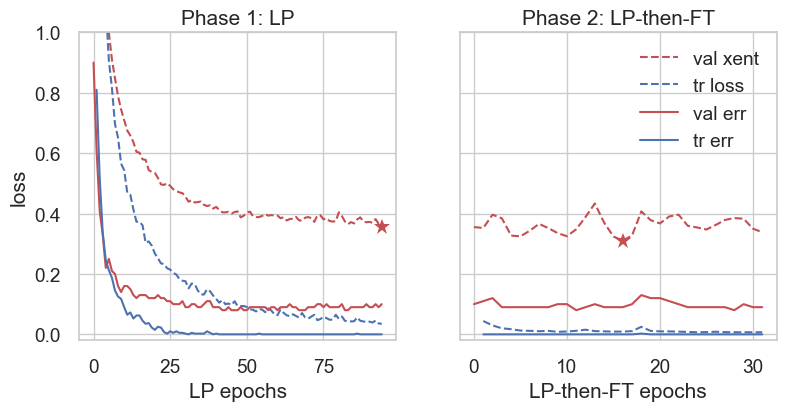

In [50]:
_, axgrid = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True)

LPbest = task_two_results[('ResNet10', 'ImageNet1k', 'phase1')]
FTbest = task_two_results[('ResNet10', 'ImageNet1k', 'phase2')]


eps = [e for e in LPbest['epochs'] if e <= LPbest['best_epoch']]
axgrid[0].plot(eps, LPbest['va']['xent'][:len(eps)], '--', color='r', label='val xent')
axgrid[0].plot(eps, LPbest['tr']['loss'][:len(eps)], '--', color='b')
axgrid[0].plot(eps, LPbest['va']['err'][:len(eps)], color='r', label='val')
axgrid[0].plot(eps, LPbest['tr']['err'][:len(eps)], '-', color='b')
axgrid[0].plot(LPbest['best_epoch'], LPbest['best_va_loss'], '*', color='r', markersize=12);
axgrid[0].set_title("Phase 1: LP");
axgrid[0].set_xlabel("LP epochs");
axgrid[0].set_ylabel("loss");

FTeps = FTbest['epochs']
axgrid[1].plot(FTeps, FTbest['va']['xent'], '--', color='r', label='val xent')
axgrid[1].plot(FTeps, FTbest['tr']['loss'], '--', color='b', label='tr loss')
axgrid[1].plot(FTeps, FTbest['va']['err'], '-', color='r', label='val err')
axgrid[1].plot(FTeps, FTbest['tr']['err'], '-', color='b', label='tr err')
axgrid[1].plot(FTbest['best_epoch'], FTbest['best_va_loss'], '*', color='r', markersize=12);
axgrid[1].set_title("Phase 2: LP-then-FT");
axgrid[1].set_ylim([-0.02, 1.]);
axgrid[1].set_xlabel('LP-then-FT epochs');
axgrid[1].legend(loc='upper right');


## Problem 2b: Report test-set acc for both the phase1 and phase 2

These numbers will be presented in your report.

In [42]:
# TODO compute test acc after the LP phase
tar_acc_2 = {}
tar_acc_2[('ResNet10', 'ImageNet1k', 'phase1')] = eval_acc(resnet10_in_lp, device, test_loader)

In [43]:
# TODO compute test acc after the FT-3 phase
tar_acc_2[('ResNet10', 'ImageNet1k', 'phase2')] = eval_acc(resnet10_in_ft, device, test_loader)

In [44]:
print(tar_acc_2)

{('ResNet10', 'ImageNet1k', 'phase1'): 0.8071428571428572, ('ResNet10', 'ImageNet1k', 'phase2'): 0.8214285714285714}
